In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import numpy as np
import math

%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device=",device)
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

device= cuda


In [4]:
class vggNet(torch.nn.Module):
    def __init__(self,in_channels=1,num_classes=10):
        self.in_channels = in_channels
        self.num_classes = num_classes
        
        super(vggNet,self).__init__()
        self.conv_layers = nn.Sequential(

            nn.Conv2d(self.in_channels,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
           
            
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=512,out_features=4096),
            nn.ReLU(),
            nn.Dropout1d(0.5),
            nn.Linear(in_features=4096,out_features=4096),
            nn.ReLU(),
            nn.Dropout1d(0.5),
            nn.Linear(4096,self.num_classes)

            )
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer  = optim.SGD(self.parameters(),lr=0.001,momentum=0.9)
    def forward(self,x):
        x=self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    def do_train(self,train_data_loder,test_data_loder,num_epochs,batch_size,device):
        train_len = len(train_data_loder)*batch_size
        test_len = len(test_data_loder)*batch_size
        total_step = len(train_data_loder)*batch_size
        # Record loss
        train_loss = []
        test_loss =  []

        # Record accuracy
        train_accuracy  = []
        test_accuracy = []
        
        for epoch in range(num_epochs):
            # training the model 
            self.train()
            for i,(images,labels) in enumerate(train_data_loder):
                #move the input data to device
                images=images.to(device)
                labels=labels.to(device)
                print('*'*20, torch.mean(images[0]))
                #run the model on the input data
                outputs = model(images)
                # cal the loss
                loss = self.criterion(outputs,labels)
                # backprop
                self.optimizer.zero_grad()
                # do backprop
                loss.backward()
                # update the params
                self.optimizer.step() 
            #  evaluating the model to compute the training, testing  accuracy, and loss  at the current epoch
            self.eval()
            correct_predictions =0
            loss = 0
            with torch.no_grad():
                for data in train_data_loder:
                    #accuracy
                    images,true_labels = data
                    images,true_labels = images.to(device),true_labels.to(device)
                    nn_outputs=self(images).to(device)
                    _,predicted = torch.max(nn_outputs.data,1)
                    correct_predictions += (predicted == true_labels).sum().item()
                    #loss
                    loss += self.criterion(nn_outputs,true_labels).item()
            train_loss.append( loss / train_len )
            train_accuracy.append(correct_predictions / train_len )
            train_acc_i = correct_predictions / train_len 
            # For Test accuracy and test loss
            correct_predictions =0
            loss = 0
            with torch.no_grad():
                for data in test_data_loder:
                    #accuracy
                    images,true_labels = data
                    images,true_labels = images.to(device),true_labels.to(device)
                    nn_outputs=self(images).to(device)
                    _,predicted = torch.max(nn_outputs.data,1)
                    correct_predictions += (predicted == true_labels).sum().item()
                    #loss
                    loss += self.criterion(nn_outputs,true_labels).item()
            test_loss.append( loss / test_len )
            test_accuracy.append(correct_predictions / test_len )
            test_acc_i = correct_predictions / test_len 
            print(f'Epoch done [{epoch+1}], training-Acccuracy: {train_acc_i:.4f} , testing-accuracy:{test_acc_i }')
        print('Finished')
        return train_loss, train_accuracy, test_loss, test_accuracy
    def evaluate_(self,eval_datas,batch_size,device): 
        self.eval()
        correct_predictions =0
        loss = 0
        test_loss = []
        test_accuracy = []
        test_len = len(eval_datas)*batch_size
        with torch.no_grad():
            for data in eval_datas:
                #accuracy
                images,true_labels = data
                images,true_labels = images.to(device),true_labels.to(device)
                nn_outputs=self(images).to(device)
                _,predicted = torch.max(nn_outputs.data,1)
                correct_predictions += (predicted == true_labels).sum().item()
                #loss
                loss += self.criterion(nn_outputs,true_labels).item()
        test_loss.append( loss / test_len )
        test_accuracy.append(correct_predictions / test_len )
        test_acc_i = correct_predictions / test_len 
        return test_loss,test_accuracy

In [3]:
PATH = './model_2a'
model = torch.load(PATH,map_location=torch.device(device))
batchSize  = 1

# Horizontal flip

In [5]:
testing_tensor = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(root='./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Resize((32,32)),
                                  torchvision.transforms.Normalize(mean=0.1307,std=0.3081),
                                 torchvision.transforms.RandomHorizontalFlip(p=1)
                             ])),
                            batch_size = batchSize
                                )
test_loss_horizontal,test_accuracy_horizontal=model.evaluate_(testing_tensor,batchSize,device)

# Vertical Flip

In [6]:
testing_tensor = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(root='./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Resize((32,32)),
                                 torchvision.transforms.Normalize(mean=0.1307,std=0.3081),
                                 torchvision.transforms.RandomVerticalFlip(p=1)
                             ])),
                            batch_size = batchSize)
test_loss_vertical,test_accuracy_vertical=model.evaluate_(testing_tensor,batchSize,device)

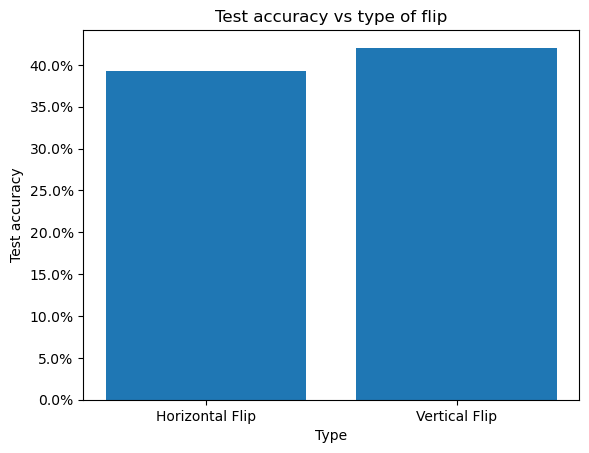

In [7]:
plt.bar(["Horizontal Flip", "Vertical Flip"],[test_accuracy_horizontal[0]*100, test_accuracy_vertical[0]*100])
plt.title('Test accuracy vs type of flip')
plt.xlabel('Type')
plt.ylabel('Test accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig('E2Q3_e')

# Gaussian

In [8]:
# # Gaussian 0.01
batchSize=1
testing_tensor = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(root='./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Resize((32,32)),
                                 torchvision.transforms.Normalize(mean=0.1307,std=0.3081),
                                 torchvision.transforms.Lambda(lambda x : x + 0.1*torch.randn_like(x))
                             ])),
                            batch_size = batchSize)
_,gaussian_001=model.evaluate_(testing_tensor,batchSize,device)
gg_loss001= gaussian_001[0]*100
print('accuracy with 0.01 gaussian noise is %.2f%%'% gg_loss001)

accuracy with 0.01 gaussian noise is 98.69%


In [9]:
# Gaussian 0.1
batchSize=1
testing_tensor = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(root='./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Resize((32,32)),
                                 torchvision.transforms.Normalize(mean=0.1307,std=0.3081),
                                 torchvision.transforms.Lambda(lambda x : x + math.sqrt(0.1)*torch.randn_like(x))
                             ])),
                            batch_size = batchSize)
_,gaussian_01=model.evaluate_(testing_tensor,batchSize,device)
gg_loss01= gaussian_01[0]*100
print('accuracy with 0.1 gaussian noise is %.2f%%'% gg_loss01)

accuracy with 0.1 gaussian noise is 95.42%


In [10]:
# Gaussian 1
batchSize=1
testing_tensor = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(root='./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Resize((32,32)),
                                 torchvision.transforms.Lambda(lambda x : x + 1*torch.randn_like(x))
                             ])),
                            batch_size = batchSize)
_,gaussian_1=model.evaluate_(testing_tensor,batchSize,device)
gg_loss1= gaussian_1[0]*100
print('accuracy with 1 gaussian noise is %.2f%%'% gg_loss1)

accuracy with 1 gaussian noise is 9.74%


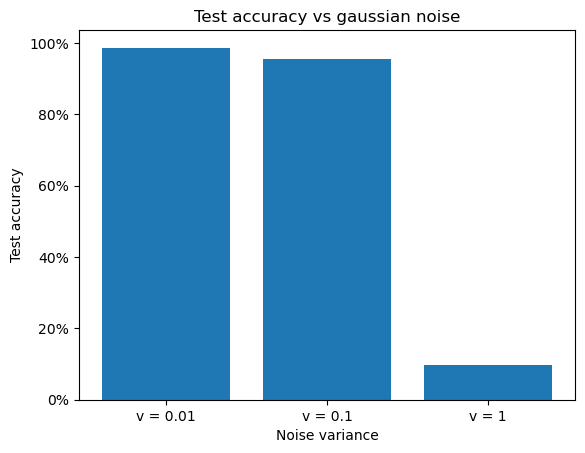

In [12]:
plt.bar(["v = 0.01", "v = 0.1", "v = 1"],[gg_loss001, gg_loss01, gg_loss1])
plt.title('Test accuracy vs gaussian noise')
plt.xlabel('Noise variance')
plt.ylabel('Test accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig('E2Q3_f')